In [39]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle
import datetime as date
import math
import seaborn as sns
sns.set()

from scipy import stats
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
%matplotlib inline

In [40]:
with open('modeling_data','rb') as read_file:
    df = pickle.load(read_file)

In [41]:
df.head(3)

,weight,camera,price,screen_size,length,width,thickness,battery,memory,RAM
1,169.0,13.0,250.0,5.5,153.8,75.6,8.5,4080.0,32000.0,3000.0
2,166.0,13.0,230.0,5.5,153.3,78.8,8.5,4020.0,32000.0,3000.0
3,125.0,8.0,110.0,5.0,145.7,71.2,8.4,2000.0,8000.0,1000.0


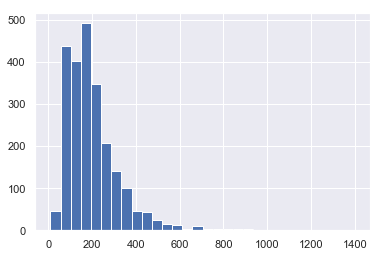

In [42]:
df.price.hist(bins = 30)

In [43]:
df['log_price'] = np.log(df['price'])

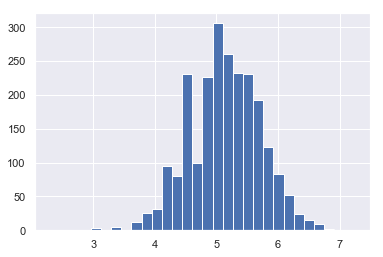

In [44]:
df.log_price.hist(bins = 30)

In [45]:
df.columns

Index(['weight', 'camera', 'price', 'screen_size', 'length', 'width',
       'thickness', 'battery', 'memory', 'RAM', 'log_price'],
      dtype='object')

In [46]:
X = df.loc[:,['weight', 'camera', 'screen_size', 'length', 'width', 'thickness',
               'battery', 'memory', 'RAM']]

y = df['log_price']


In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2819
Data columns (total 9 columns):
weight         2344 non-null float64
camera         2344 non-null float64
screen_size    2344 non-null float64
length         2344 non-null float64
width          2344 non-null float64
thickness      2344 non-null float64
battery        2344 non-null float64
memory         2344 non-null float64
RAM            2344 non-null float64
dtypes: float64(9)
memory usage: 183.1 KB


## Test Linearity in parameters

In [48]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [49]:
s = 2344
x = np.random.uniform(low=-5, high=5, size=s)

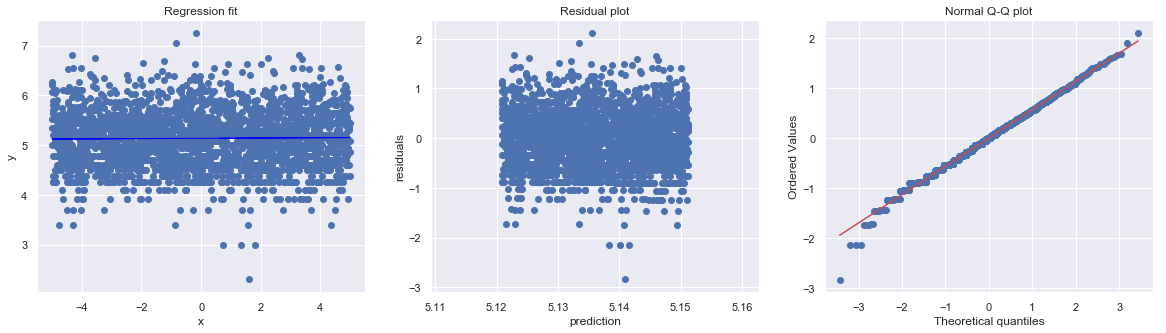

In [50]:
diagnostic_plot(x.reshape(s,1), y)

## Test Normally distributed Residuals

In [51]:
lr = LinearRegression()
fit = lr.fit(X,y)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


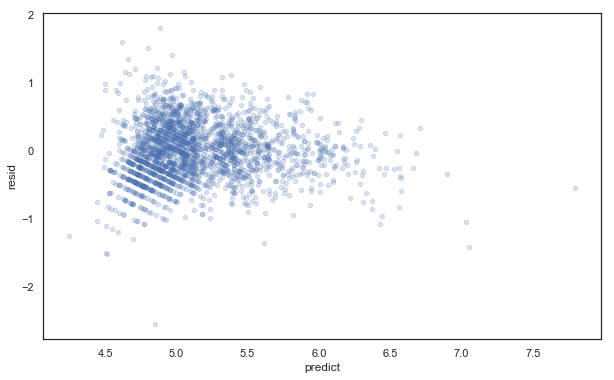

In [52]:
df['predict']=fit.predict(X)
df['resid']=y-df.predict
with sns.axes_style('white'):
    plot=df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

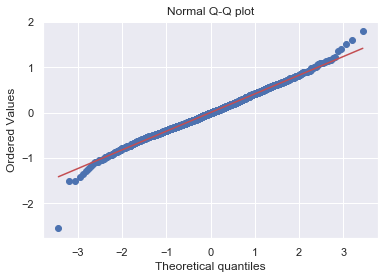

In [53]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(df['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

## Error term must have Constant Variance

In [54]:
model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 2.963e+04
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:50:19   Log-Likelihood:                -1612.3
No. Observations:                2344   AIC:                             3243.
Df Residuals:                    2335   BIC:                             3295.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
weight         -0.0066      0.000    -19.697      0.000      -0.007      -0.006
camera          0.0684      0.004     19.135      0.000       0.061       0.075
screen_size     0.0622      0.035      1.780      0.075      -0.006       0.131
length          0.0200      0.001     15.003      0.000       0.017       0.023
width           0.0106      0.002      5.449      0.000       0.007       0.014
thickness       0.1716      0.004     42.933      0.000       0.164       0.179
battery     -4.692e-05   1.61e-05     -2.916      0.004   -7.85e-05   -1.54e-05
memory       8.149e-06   1.02e-06      8.008      0.000    6.15e-06    1.01e-05
RAM          4.809e-05   1.97e-05      2.443      0.015    9.49e-06    8.67e-05
==============================================================================
Omnibus:                       63.624   Durbin-Watson:                   1.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.211
Skew:                           0.065   Prob(JB):                     3.97e-33
Kurtosis:                       4.229   Cond. No.                     7.12e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


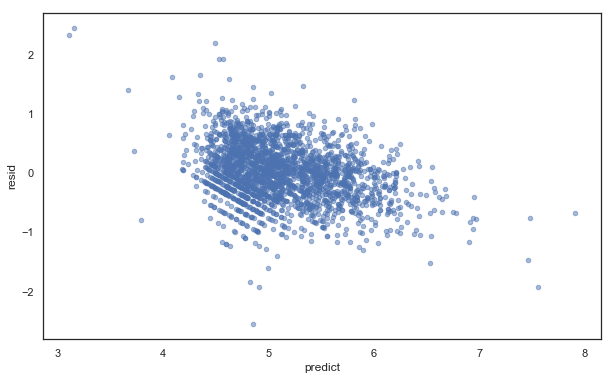

In [55]:
# create residual plot
df['predict']=fit.predict(X)
df['resid']= y-df.predict
with sns.axes_style('white'):
    plot = df.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6))

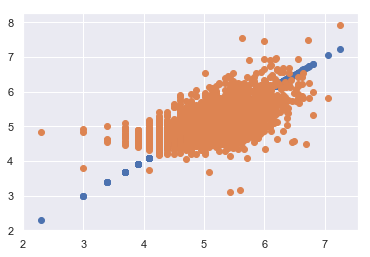

In [57]:
plt.scatter(df.log_price,y)
plt.scatter(df.log_price,df.predict);

## Trying Boxcox

Lambda: 1.2093286421277483


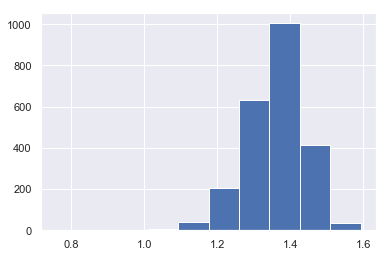

In [58]:
lamb=stats.boxcox_normmax(df.log_price, brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)
y_t=(np.power(df.log_price,-0.2282)-1)/-0.2282

plt.hist(y_t);

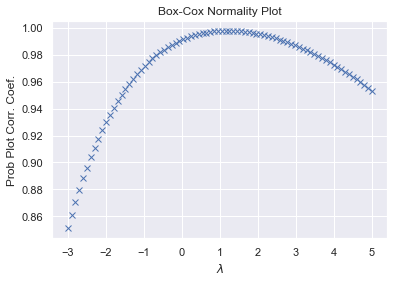

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(df.log_price, -3, 5, plot=ax)

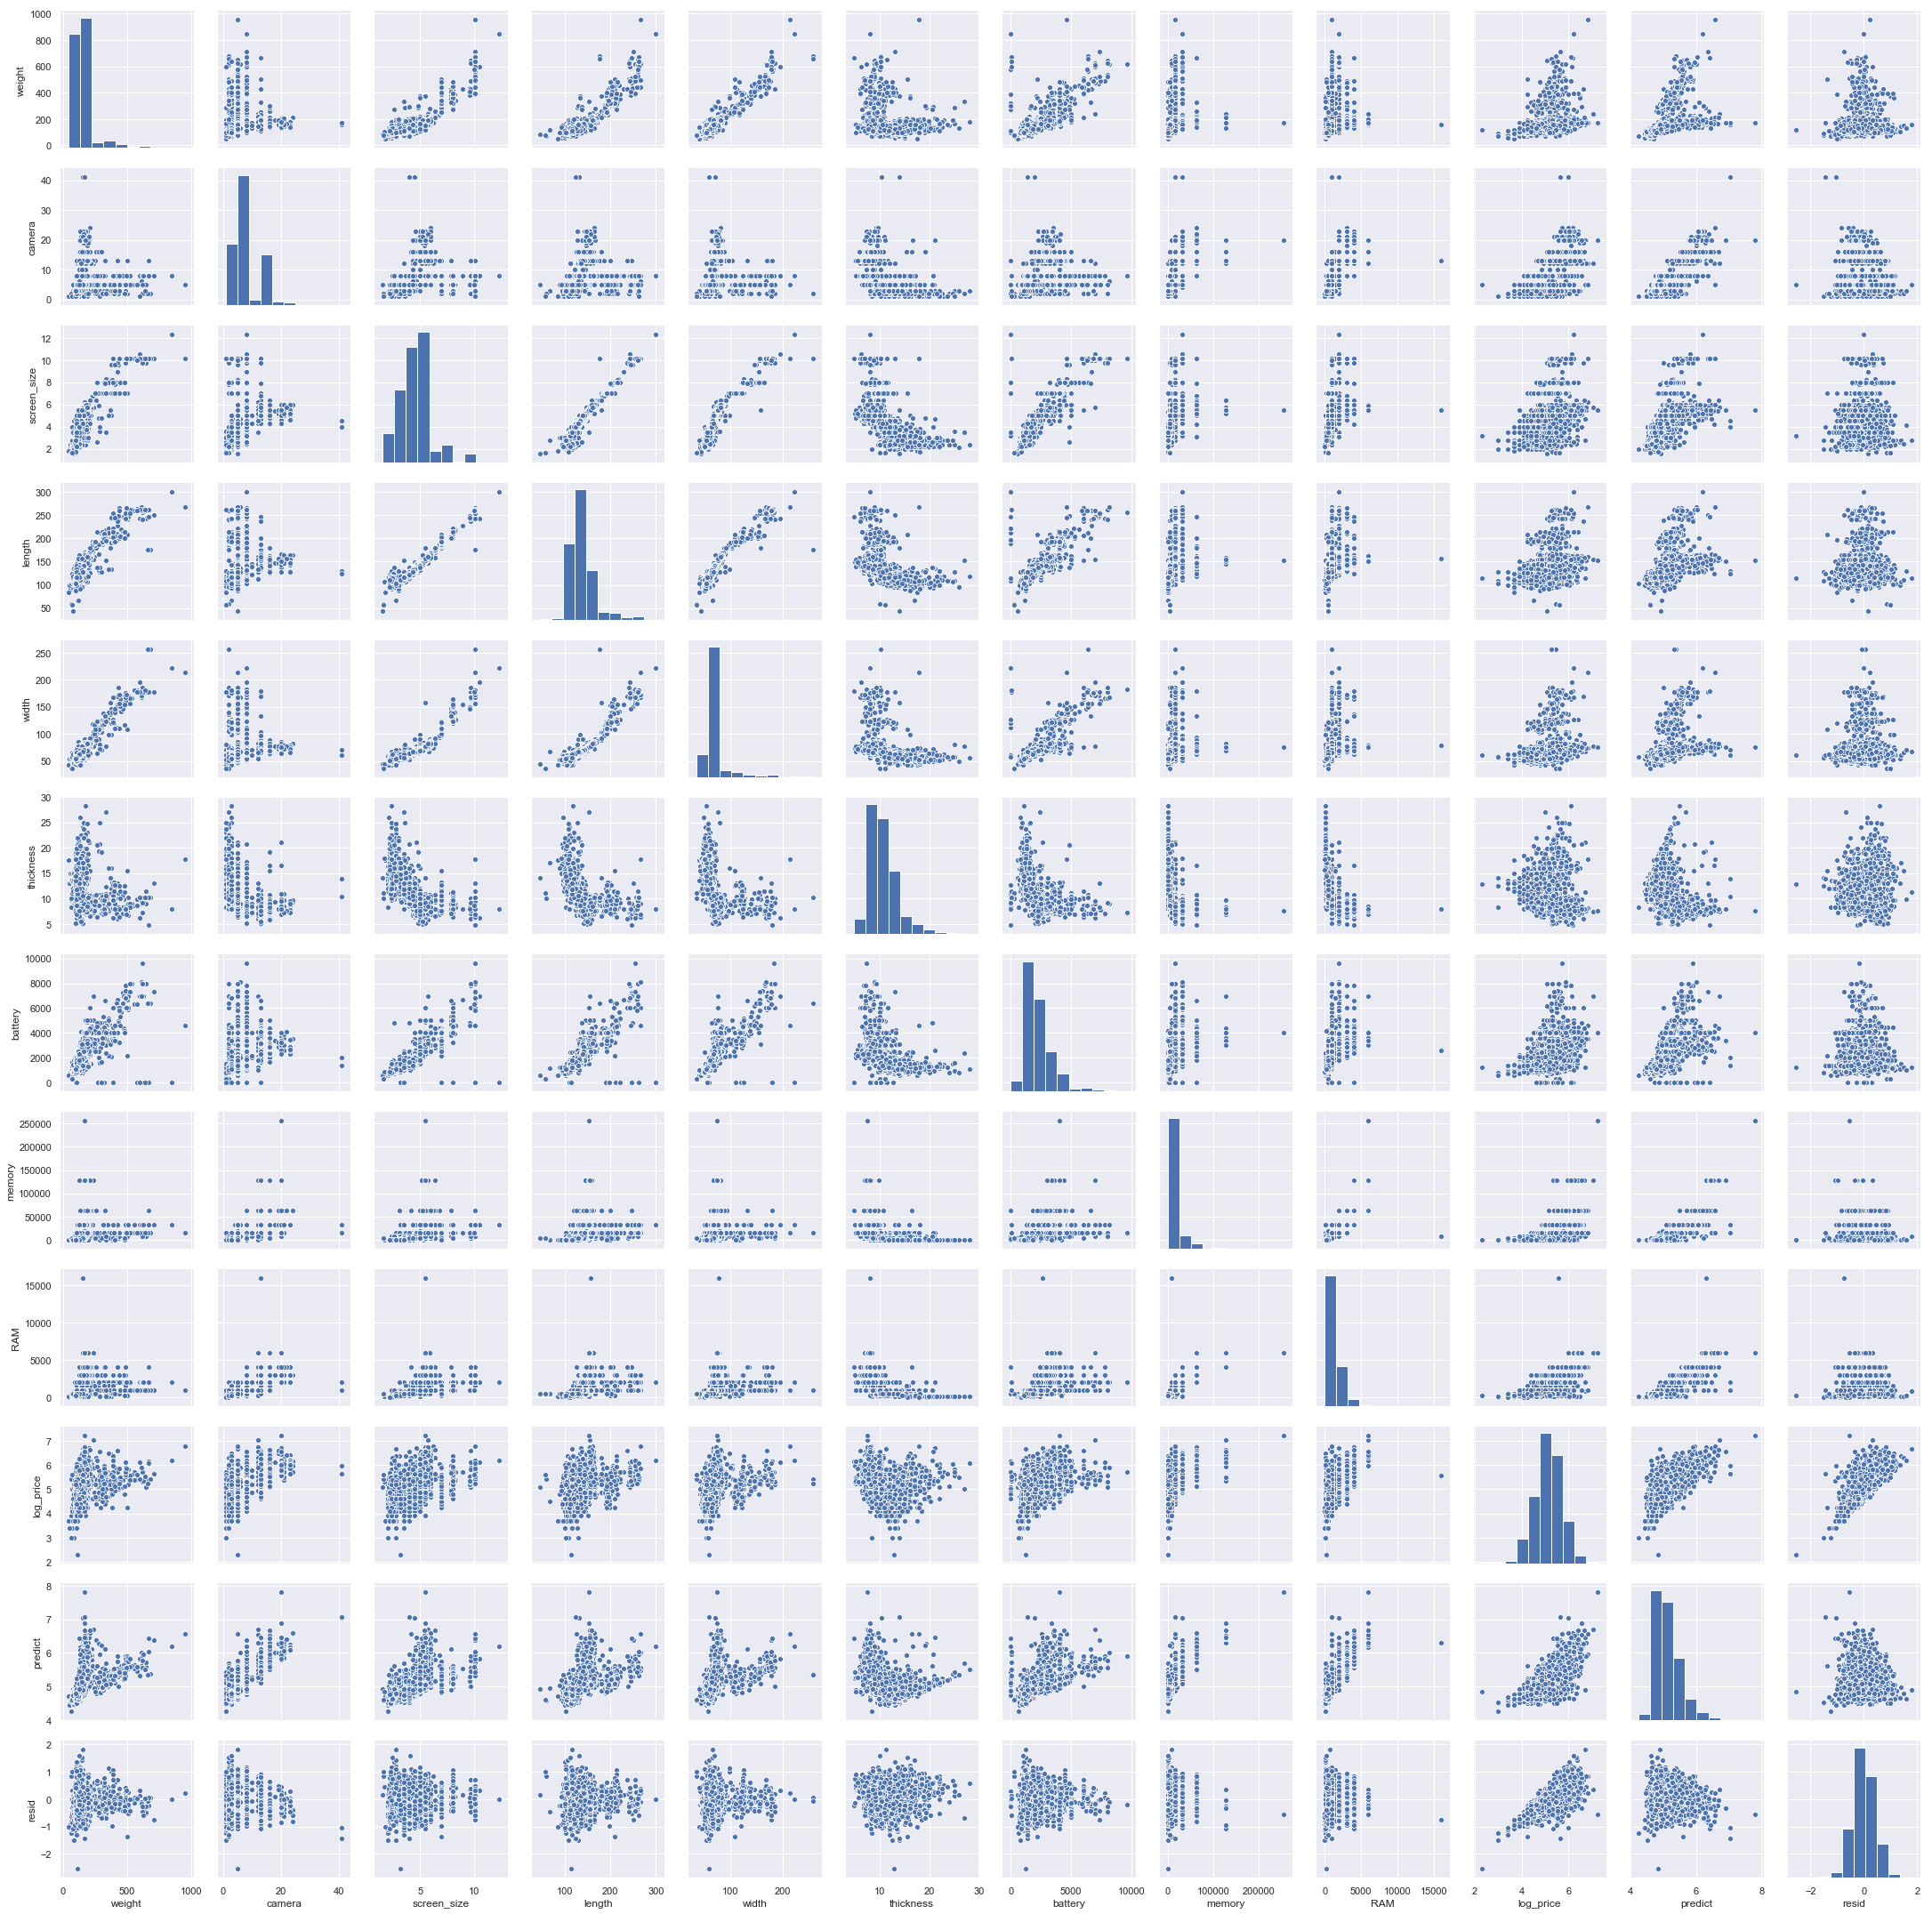

In [35]:
sns.pairplot(df)